# Stateful LSTM using PyTorch

[References]
- [PyTorch Discussion](https://discuss.pytorch.org/t/confusion-regarding-pytorch-lstms-compared-to-keras-stateful-lstm/44502)
- [PyTorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

## What is stateful LSTM?

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_features = X.shape[1]
print('Number of features:', num_features)

cpu
Number of features: 14


## Data Loader for Stateful-LSTM

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, X_array, y_array, sampling_rate, sequence_stride, sequence_length, delay):
        super(Dataset, self).__init__()

        self.sr = sampling_rate
        self.seq_stride = sequence_stride
        self.seq_len = sequence_length
        self.delay = delay
        self.X = torch.tensor(X_array).float()
        self.y = torch.tensor(y_array).float()

    def __len__(self):
        return (self.X.size(0) - self.delay)//self.seq_stride

    def __getitem__(self, i): 
        idx = np.arange(i*self.seq_stride, i*self.seq_stride + self.sr*self.seq_len, self.sr)
        return self.X[idx], self.y[i*self.seq_stride + self.delay]

In [4]:
int_sequence = np.arange(130)
dummy_dataset = SequenceDataset(int_sequence, int_sequence,
                                sampling_rate=3, sequence_stride=3, sequence_length=5, 
                                delay=20)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)

In [5]:
for inputs, targets in dummy_loader:
    # inputs shape : (batch_size, sequence_length)
    # targets shape : (batch_size, )
    print("====================")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 3, 6, 9, 12] 20
[3, 6, 9, 12, 15] 23
[6, 9, 12, 15, 18] 26
[9, 12, 15, 18, 21] 29
[12, 15, 18, 21, 24] 32
[15, 18, 21, 24, 27] 35
[18, 21, 24, 27, 30] 38
[21, 24, 27, 30, 33] 41
[24, 27, 30, 33, 36] 44
[27, 30, 33, 36, 39] 47
[30, 33, 36, 39, 42] 50
[33, 36, 39, 42, 45] 53
[36, 39, 42, 45, 48] 56
[39, 42, 45, 48, 51] 59
[42, 45, 48, 51, 54] 62
[45, 48, 51, 54, 57] 65
[48, 51, 54, 57, 60] 68
[51, 54, 57, 60, 63] 71
[54, 57, 60, 63, 66] 74
[57, 60, 63, 66, 69] 77
[60, 63, 66, 69, 72] 80
[63, 66, 69, 72, 75] 83
[66, 69, 72, 75, 78] 86
[69, 72, 75, 78, 81] 89
[72, 75, 78, 81, 84] 92
[75, 78, 81, 84, 87] 95
[78, 81, 84, 87, 90] 98
[81, 84, 87, 90, 93] 101
[84, 87, 90, 93, 96] 104
[87, 90, 93, 96, 99] 107
[90, 93, 96, 99, 102] 110
[93, 96, 99, 102, 105] 113
[96, 99, 102, 105, 108] 116
[99, 102, 105, 108, 111] 119
[102, 105, 108, 111, 114] 122
[105, 108, 111, 114, 117] 125


**To use `stateful=True` mode in LSTM (RNN), you should follow the rules below:**

- Do **NOT** shuffle the dataset
- `sequence_stride` $\times$ `batch_size` = `sequence_length` $\times$ `sampling_rate`
- Each batch need to have the same number of samples, i.e., the number of samples needs to divisible by `batch_size`.

In [6]:
# Observations will be sampled at one data point per hour
sampling_rate=6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)

sequence_stride=1
batch_size = sampling_rate*sequence_length

train_dataset = SequenceDataset(X[132:num_train_samples], 
                                y[132:num_train_samples], 
                                sampling_rate=sampling_rate, 
                                sequence_stride=1,
                                sequence_length=sequence_length,
                                delay = delay)

valid_dataset = SequenceDataset(X[432+num_train_samples:num_train_samples+num_val_samples], 
                                y[432+num_train_samples:num_train_samples+num_val_samples], 
                                sampling_rate=sampling_rate, 
                                sequence_stride=1,
                                sequence_length=sequence_length,
                                delay = delay)

test_dataset = SequenceDataset(X[433+num_train_samples + num_val_samples:],
                               y[433+num_train_samples + num_val_samples:], 
                               sampling_rate=sampling_rate, 
                               sequence_stride=1,
                               sequence_length=sequence_length,
                               delay = delay)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
for samples, targets in test_loader:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: torch.Size([720, 120, 14])
targets shape: torch.Size([720])


## Stateful LSTM model

- Using PyTorch, we store the hidden/cell state vectors from the previous batch. Then we use the vectors as the initial hidden/cell state vectors in the next batch.
- `train` and `test` functions should be changed from those for the original LSTM models.

In [9]:
class stateful_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(stateful_LSTM_model, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size  = input_size,
                            hidden_size = hidden_size,
                            num_layers  = 1,     # The number of stacked RNN layers
                            batch_first = True            # Default: False
                            )
        self.linear = nn.Linear(in_features = hidden_size, 
                                out_features=1, 
                                bias=True
                                )

    def forward(self, x, h_n, c_n):
        output, (h_n, c_n) = self.lstm(x, (h_n.detach(), c_n.detach()))
        '''
        output size : (batch_size, sequence_length, num_layers * hidden_size)
        -> hidden state vectors (NOT CELL STATE VECTORS) for each time step, for each layer.
        h_n : (num_layers, batch_size, hidden_size) 
        c_n : (num_layers, batch_size, hidden_size)
        '''
        x = h_n.view(-1, self.hidden_size)
        '''
        Reshape to (batch_size, hidden_size) : appropriate shape as linear layer input
        '''
        x = self.linear(x)
        return x, h_n, c_n

In [10]:
hidden_size=16
model = stateful_LSTM_model(input_size=num_features, hidden_size=hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 30

In [11]:
def train(model, trainloader, validloader, criterion, optimizer, epoch, device):
    
    losses = []
    val_losses = []
    model.to(device)
    model.train()

    for i in range(1, epoch+1):
        count = 0
        train_loss = 0
        h_n = torch.zeros(1, batch_size, hidden_size).to(device)
        c_n = torch.zeros(1, batch_size, hidden_size).to(device)
        for X, y in tqdm(trainloader):
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X, h_n, c_n)
            loss = criterion(output.view(-1), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            count += 1

        train_loss /= count
        losses.append(train_loss)

        count = 0
        valid_loss = 0
        h_n = torch.zeros(1, batch_size, hidden_size).to(device)
        c_n = torch.zeros(1, batch_size, hidden_size).to(device)
        with torch.no_grad():
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)

                output, h_n, c_n = model(X, h_n, c_n)
                loss = criterion(output.view(-1), y)
                valid_loss += loss.item()
                count += 1
            
        valid_loss /= count
        val_losses.append(valid_loss)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Validation Loss: %.3f \n' 
              %(i, train_loss, valid_loss))

    return losses, val_losses

In [12]:
def test(model, evalloader, criterion, device):
    eval_loss = 0
    count = 0
    model.eval()
    predictions = np.empty([0])

    h_n = torch.zeros(1, batch_size, hidden_size).to(device)
    c_n = torch.zeros(1, batch_size, hidden_size).to(device)
    with torch.no_grad():
        for X, y in evalloader:
            X = X.to(device)
            y = y.to(device)

            output, h_n, c_n = model(X, h_n, c_n)
            predictions = np.append(predictions, output.view(-1).numpy())

            loss = criterion(output.view(-1), y)
            eval_loss += loss.item()
            count += 1
        
    eval_loss /= count
    
    return predictions, eval_loss

In [13]:
train_loss, val_loss = train(model, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 349/349 [01:20<00:00,  4.36it/s]


EPOCH 1 Completed. 
 Training Loss: 110.723, Validation Loss: 50.985 



100%|██████████| 349/349 [01:21<00:00,  4.30it/s]


EPOCH 2 Completed. 
 Training Loss: 51.880, Validation Loss: 29.329 



100%|██████████| 349/349 [00:56<00:00,  6.19it/s]


EPOCH 3 Completed. 
 Training Loss: 32.636, Validation Loss: 20.304 



100%|██████████| 349/349 [00:54<00:00,  6.42it/s]


EPOCH 4 Completed. 
 Training Loss: 23.305, Validation Loss: 15.667 



100%|██████████| 349/349 [00:52<00:00,  6.63it/s]


EPOCH 5 Completed. 
 Training Loss: 18.380, Validation Loss: 13.477 



100%|██████████| 349/349 [00:52<00:00,  6.62it/s]


EPOCH 6 Completed. 
 Training Loss: 15.624, Validation Loss: 12.231 



100%|██████████| 349/349 [00:51<00:00,  6.73it/s]


EPOCH 7 Completed. 
 Training Loss: 13.939, Validation Loss: 11.528 



100%|██████████| 349/349 [00:51<00:00,  6.75it/s]


EPOCH 8 Completed. 
 Training Loss: 12.897, Validation Loss: 11.067 



100%|██████████| 349/349 [00:52<00:00,  6.69it/s]


EPOCH 9 Completed. 
 Training Loss: 12.168, Validation Loss: 10.759 



100%|██████████| 349/349 [00:52<00:00,  6.65it/s]


EPOCH 10 Completed. 
 Training Loss: 11.668, Validation Loss: 10.546 



100%|██████████| 349/349 [00:53<00:00,  6.55it/s]


EPOCH 11 Completed. 
 Training Loss: 11.312, Validation Loss: 10.402 



100%|██████████| 349/349 [00:58<00:00,  5.96it/s]


EPOCH 12 Completed. 
 Training Loss: 11.044, Validation Loss: 10.260 



100%|██████████| 349/349 [00:58<00:00,  6.00it/s]


EPOCH 13 Completed. 
 Training Loss: 10.840, Validation Loss: 10.196 



100%|██████████| 349/349 [00:53<00:00,  6.50it/s]


EPOCH 14 Completed. 
 Training Loss: 10.683, Validation Loss: 10.067 



100%|██████████| 349/349 [00:55<00:00,  6.33it/s]


EPOCH 15 Completed. 
 Training Loss: 10.547, Validation Loss: 9.927 



100%|██████████| 349/349 [00:52<00:00,  6.65it/s]


EPOCH 16 Completed. 
 Training Loss: 10.401, Validation Loss: 9.903 



100%|██████████| 349/349 [00:53<00:00,  6.50it/s]


EPOCH 17 Completed. 
 Training Loss: 10.292, Validation Loss: 9.942 



100%|██████████| 349/349 [00:54<00:00,  6.41it/s]


EPOCH 18 Completed. 
 Training Loss: 10.202, Validation Loss: 9.791 



100%|██████████| 349/349 [00:53<00:00,  6.53it/s]


EPOCH 19 Completed. 
 Training Loss: 10.104, Validation Loss: 9.808 



100%|██████████| 349/349 [00:53<00:00,  6.48it/s]


EPOCH 20 Completed. 
 Training Loss: 10.059, Validation Loss: 9.704 



100%|██████████| 349/349 [00:53<00:00,  6.58it/s]


EPOCH 21 Completed. 
 Training Loss: 9.977, Validation Loss: 9.677 



100%|██████████| 349/349 [00:50<00:00,  6.94it/s]


EPOCH 22 Completed. 
 Training Loss: 9.922, Validation Loss: 9.671 



100%|██████████| 349/349 [00:50<00:00,  6.91it/s]


EPOCH 23 Completed. 
 Training Loss: 9.864, Validation Loss: 9.618 



100%|██████████| 349/349 [00:50<00:00,  6.95it/s]


EPOCH 24 Completed. 
 Training Loss: 9.798, Validation Loss: 9.605 



100%|██████████| 349/349 [00:50<00:00,  6.95it/s]


EPOCH 25 Completed. 
 Training Loss: 9.749, Validation Loss: 9.600 



100%|██████████| 349/349 [00:50<00:00,  6.93it/s]


EPOCH 26 Completed. 
 Training Loss: 9.714, Validation Loss: 9.578 



100%|██████████| 349/349 [00:50<00:00,  6.94it/s]


EPOCH 27 Completed. 
 Training Loss: 9.689, Validation Loss: 9.737 



100%|██████████| 349/349 [00:50<00:00,  6.95it/s]


EPOCH 28 Completed. 
 Training Loss: 9.665, Validation Loss: 9.611 



100%|██████████| 349/349 [00:50<00:00,  6.93it/s]


EPOCH 29 Completed. 
 Training Loss: 9.609, Validation Loss: 9.593 



100%|██████████| 349/349 [00:53<00:00,  6.56it/s]


EPOCH 30 Completed. 
 Training Loss: 9.541, Validation Loss: 9.598 



In [14]:
predictions, eval_loss = test(model, test_loader, criterion, device)

In [15]:
test_targets = np.empty([0])

for X, y in test_loader:
    test_targets = np.append(test_targets, y.numpy())

test_num = test_targets.shape[0]
print(test_num)

82800


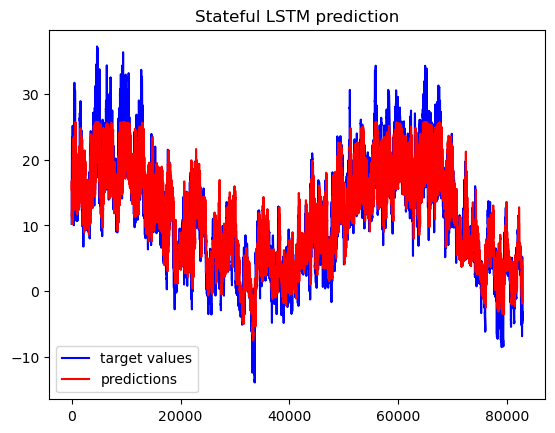

In [16]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

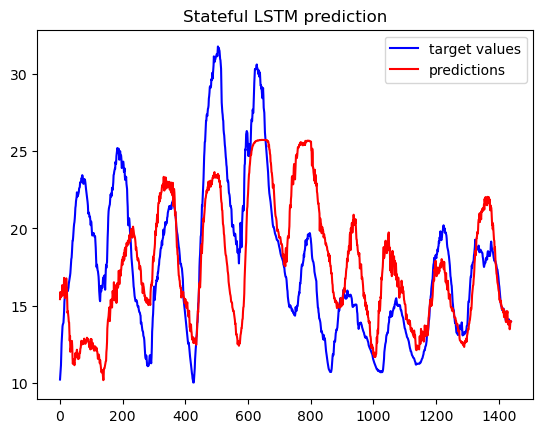

In [17]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions[:1440], label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

## Future Works

Compare between stateful LSTM with `shorter sequence length` and that with `longer sequence length`.